In [1]:
import numpy as np
from keras.datasets import mnist
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchvision import transforms
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torch
import torch.optim as optim

In [2]:
def add_noise(img, noise_type="gaussian", mean=0, var=1):
    row, col = 28, 28
    img = img.astype(np.float32)
    sigma = var ** .5

    if noise_type == "gaussian":
        noise = np.random.normal(mean, sigma, img.shape)
        noise = noise.reshape(row, col)
        img = img + noise
        return img

    if noise_type == "speckle":
        noise = np.random.gamma(mean, scale=sigma, size=img.shape)
        img = img * noise
        return img

def snr(img1, img2):
    sz = img1.shape
    acc_num = 0
    acc_den = 0

    for i in range(0, sz[0]):
        for j in range(0, sz[1]):
            acc_num += img1[i][j] ** 2
            acc_den += (img1[i][j] - img2[i][j]) ** 2

    return acc_num / acc_den

def psnr(img1, img2):
    sz = img1.shape
    acc_mse = 0

    for i in range(0, sz[0]):
        for j in range(0, sz[1]):
            acc_mse += (img1[i][j] - img2[i][j]) ** 2

    acc_mse /= (sz[0] * sz[1])

    return 10 * np.log(255 ** 2 / acc_mse)

In [3]:
(xtrain, ytrain), (xtest, ytest) = mnist.load_data()

noises = ["gaussian", "speckle"]
mean = 0
var = 10000.
lb = 1.1
a = lb
scale = 1 / (lb - 1)
noise_ct = 0
noise_id = 0
traindata = np.zeros((60000, 28, 28))

for idx in tqdm(range(len(xtrain))):
    traindata[idx] = add_noise(xtrain[idx], noise_type=noises[noise_id], mean=mean, var=var)


print("\n{} noise addition completed to images".format(noises[noise_id]))

testdata = np.zeros((10000, 28, 28))

for idx in tqdm(range(len(xtest))):
    x = add_noise(xtest[idx], noise_type=noises[noise_id], mean=mean, var=var)
    testdata[idx] = x

print("\n{} noise addition completed to images".format(noises[noise_id]))

100%|██████████| 60000/60000 [00:04<00:00, 12706.74it/s]



gaussian noise addition completed to images


100%|██████████| 10000/10000 [00:00<00:00, 14900.19it/s]


gaussian noise addition completed to images


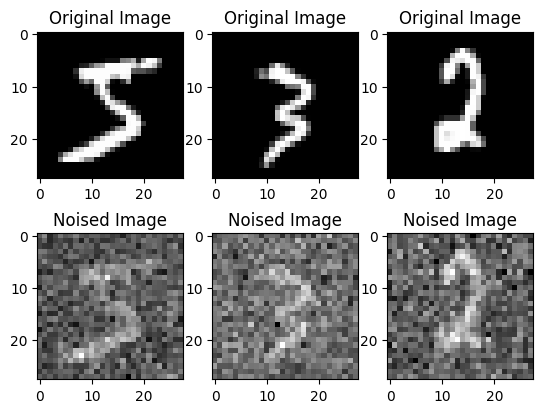

SNR:  0.7799878976399073
PSNR:  19.012387023128007


In [95]:
f, axes = plt.subplots(2, 3)

# showing images with gaussian noise
axes[0, 0].imshow(xtrain[0], cmap="gray")
axes[0, 0].set_title("Original Image")
axes[1, 0].imshow(traindata[0], cmap='gray')
axes[1, 0].set_title("Noised Image")

# showing images with speckle noise
axes[0, 1].imshow(xtrain[25000], cmap='gray')
axes[0, 1].set_title("Original Image")
axes[1, 1].imshow(traindata[25000], cmap="gray")
axes[1, 1].set_title("Noised Image")

# showing images with speckle noise
axes[0, 2].imshow(xtrain[10100], cmap='gray')
axes[0, 2].set_title("Original Image")
axes[1, 2].imshow(traindata[10100], cmap="gray")
axes[1, 2].set_title("Noised Image")
plt.show()

snr_estim = snr(xtrain[0], traindata[0])
psnr_estim = psnr(xtrain[0], traindata[0])

print("SNR: ", snr_estim)
print("PSNR: ", psnr_estim)

In [83]:
class noisedDataset(Dataset):

    def __init__(self, datasetnoised, datasetclean, labels, transform):
        self.noise = datasetnoised
        self.clean = datasetclean
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.noise)

    def __getitem__(self, idx):
        xNoise = self.noise[idx]
        xClean = self.clean[idx]
        y = self.labels[idx]

        if self.transform != None:
            xNoise = self.transform(xNoise)
            xClean = self.transform(xClean)

        return (xNoise, xClean, y)

In [84]:
tsfms = transforms.Compose([transforms.ToTensor()])

trainset = noisedDataset(traindata, xtrain, ytrain, tsfms)
testset = noisedDataset(testdata, xtest, ytest, tsfms)

batch_size = 32

trainloader = DataLoader(trainset, batch_size=32, shuffle=True)
testloader = DataLoader(testset, batch_size=1, shuffle=True)

In [85]:
class denoising_model(nn.Module):
    def __init__(self):
        super(denoising_model, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 256),
            nn.ReLU(True),
            nn.Linear(256, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True)

        )

        self.decoder = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(True),
            nn.Linear(128, 256),
            nn.ReLU(True),
            nn.Linear(256, 28 * 28),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)

        return x

In [96]:
from torchsummary import summary

model = denoising_model()

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

model.to(device)

summary(model, (1, 28*28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 256]         200,960
              ReLU-2               [-1, 1, 256]               0
            Linear-3               [-1, 1, 128]          32,896
              ReLU-4               [-1, 1, 128]               0
            Linear-5                [-1, 1, 64]           8,256
              ReLU-6                [-1, 1, 64]               0
            Linear-7               [-1, 1, 128]           8,320
              ReLU-8               [-1, 1, 128]               0
            Linear-9               [-1, 1, 256]          33,024
             ReLU-10               [-1, 1, 256]               0
           Linear-11               [-1, 1, 784]         201,488
          Sigmoid-12               [-1, 1, 784]               0
Total params: 484,944
Trainable params: 484,944
Non-trainable params: 0
-------------------------------

In [86]:
if torch.cuda.is_available() == True:
    device = "cuda:0"
else:
    device = "cpu"

print(device)

model = denoising_model().to(device)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-5)

epochs = 100
l = len(trainloader)
losslist = list()
epochloss = 0
running_loss = 0

cuda:0


In [87]:
image_test = testloader.sampler.data_source.noise[0]
image_test_clean = testloader.sampler.data_source.clean[0]

plt.figure()
plt.imshow(image_test)
plt.figure()
plt.imshow(image_test_clean)

image_test = torch.from_numpy(image_test)
image_test = image_test.view(1, -1).type(torch.FloatTensor)

image_test = image_test.to(device)

Entering Epoch:  0


100%|██████████| 1875/1875 [00:06<00:00, 288.40it/s]


======> epoch: 0/100, Loss:0.07962702214717865
Entering Epoch:  1


100%|██████████| 1875/1875 [00:06<00:00, 302.69it/s]


======> epoch: 1/100, Loss:0.07496523857116699
Entering Epoch:  2


100%|██████████| 1875/1875 [00:06<00:00, 301.13it/s]


======> epoch: 2/100, Loss:0.06913315504789352
Entering Epoch:  3


100%|██████████| 1875/1875 [00:06<00:00, 290.07it/s]


======> epoch: 3/100, Loss:0.06214647740125656
Entering Epoch:  4


100%|██████████| 1875/1875 [00:06<00:00, 280.34it/s]


======> epoch: 4/100, Loss:0.06523916870355606
Entering Epoch:  5


100%|██████████| 1875/1875 [00:06<00:00, 277.76it/s]


======> epoch: 5/100, Loss:0.05700043588876724
Entering Epoch:  6


100%|██████████| 1875/1875 [00:06<00:00, 303.18it/s]


======> epoch: 6/100, Loss:0.052059125155210495
Entering Epoch:  7


100%|██████████| 1875/1875 [00:06<00:00, 307.34it/s]


======> epoch: 7/100, Loss:0.04967932775616646
Entering Epoch:  8


100%|██████████| 1875/1875 [00:06<00:00, 285.60it/s]


======> epoch: 8/100, Loss:0.05939473956823349
Entering Epoch:  9


100%|██████████| 1875/1875 [00:06<00:00, 286.19it/s]


======> epoch: 9/100, Loss:0.05209633335471153
Entering Epoch:  10


100%|██████████| 1875/1875 [00:06<00:00, 275.33it/s]


======> epoch: 10/100, Loss:0.054852526634931564
Entering Epoch:  11


100%|██████████| 1875/1875 [00:06<00:00, 299.69it/s]


======> epoch: 11/100, Loss:0.049114130437374115
Entering Epoch:  12


100%|██████████| 1875/1875 [00:06<00:00, 287.39it/s]


======> epoch: 12/100, Loss:0.04652828350663185
Entering Epoch:  13


100%|██████████| 1875/1875 [00:06<00:00, 303.22it/s]


======> epoch: 13/100, Loss:0.03872457146644592
Entering Epoch:  14


100%|██████████| 1875/1875 [00:06<00:00, 278.57it/s]


======> epoch: 14/100, Loss:0.04647677019238472
Entering Epoch:  15


100%|██████████| 1875/1875 [00:06<00:00, 291.07it/s]


======> epoch: 15/100, Loss:0.04575435817241669
Entering Epoch:  16


100%|██████████| 1875/1875 [00:06<00:00, 302.43it/s]


======> epoch: 16/100, Loss:0.0433904230594635
Entering Epoch:  17


100%|██████████| 1875/1875 [00:05<00:00, 334.88it/s]


======> epoch: 17/100, Loss:0.0391998291015625
Entering Epoch:  18


100%|██████████| 1875/1875 [00:05<00:00, 323.55it/s]


======> epoch: 18/100, Loss:0.039427436888217926
Entering Epoch:  19


100%|██████████| 1875/1875 [00:06<00:00, 291.45it/s]


======> epoch: 19/100, Loss:0.042993608862161636
Entering Epoch:  20


100%|██████████| 1875/1875 [00:06<00:00, 289.34it/s]


======> epoch: 20/100, Loss:0.04058127477765083
Entering Epoch:  21


100%|██████████| 1875/1875 [00:06<00:00, 282.61it/s]


======> epoch: 21/100, Loss:0.04041636735200882
Entering Epoch:  22


100%|██████████| 1875/1875 [00:05<00:00, 322.54it/s]


======> epoch: 22/100, Loss:0.04116875305771828
Entering Epoch:  23


100%|██████████| 1875/1875 [00:06<00:00, 300.33it/s]


======> epoch: 23/100, Loss:0.038909535855054855
Entering Epoch:  24


100%|██████████| 1875/1875 [00:06<00:00, 309.89it/s]


======> epoch: 24/100, Loss:0.040161434561014175
Entering Epoch:  25


100%|██████████| 1875/1875 [00:06<00:00, 282.34it/s]


======> epoch: 25/100, Loss:0.04143791273236275
Entering Epoch:  26


100%|██████████| 1875/1875 [00:06<00:00, 288.95it/s]


======> epoch: 26/100, Loss:0.035054828971624374
Entering Epoch:  27


100%|██████████| 1875/1875 [00:06<00:00, 311.25it/s]


======> epoch: 27/100, Loss:0.037181489169597626
Entering Epoch:  28


100%|██████████| 1875/1875 [00:05<00:00, 334.31it/s]


======> epoch: 28/100, Loss:0.03948444500565529
Entering Epoch:  29


100%|██████████| 1875/1875 [00:05<00:00, 316.97it/s]


======> epoch: 29/100, Loss:0.03443113714456558
Entering Epoch:  30


100%|██████████| 1875/1875 [00:06<00:00, 291.96it/s]


======> epoch: 30/100, Loss:0.03930411487817764
Entering Epoch:  31


100%|██████████| 1875/1875 [00:06<00:00, 288.92it/s]


======> epoch: 31/100, Loss:0.03498724475502968
Entering Epoch:  32


100%|██████████| 1875/1875 [00:06<00:00, 295.62it/s]


======> epoch: 32/100, Loss:0.03120383806526661
Entering Epoch:  33


100%|██████████| 1875/1875 [00:06<00:00, 303.63it/s]


======> epoch: 33/100, Loss:0.03544754162430763
Entering Epoch:  34


100%|██████████| 1875/1875 [00:06<00:00, 310.92it/s]


======> epoch: 34/100, Loss:0.033827587962150574
Entering Epoch:  35


100%|██████████| 1875/1875 [00:06<00:00, 293.08it/s]


======> epoch: 35/100, Loss:0.031799737364053726
Entering Epoch:  36


100%|██████████| 1875/1875 [00:06<00:00, 286.76it/s]


======> epoch: 36/100, Loss:0.031723760068416595
Entering Epoch:  37


100%|██████████| 1875/1875 [00:06<00:00, 298.32it/s]


======> epoch: 37/100, Loss:0.03309657424688339
Entering Epoch:  38


100%|██████████| 1875/1875 [00:05<00:00, 323.31it/s]


======> epoch: 38/100, Loss:0.0323638953268528
Entering Epoch:  39


100%|██████████| 1875/1875 [00:05<00:00, 335.28it/s]


======> epoch: 39/100, Loss:0.03743685409426689
Entering Epoch:  40


100%|██████████| 1875/1875 [00:06<00:00, 295.21it/s]


======> epoch: 40/100, Loss:0.0312851257622242
Entering Epoch:  41


100%|██████████| 1875/1875 [00:06<00:00, 298.21it/s]


======> epoch: 41/100, Loss:0.03298227861523628
Entering Epoch:  42


100%|██████████| 1875/1875 [00:06<00:00, 276.45it/s]


======> epoch: 42/100, Loss:0.03637700155377388
Entering Epoch:  43


100%|██████████| 1875/1875 [00:05<00:00, 319.06it/s]


======> epoch: 43/100, Loss:0.03428628295660019
Entering Epoch:  44


100%|██████████| 1875/1875 [00:06<00:00, 308.32it/s]


======> epoch: 44/100, Loss:0.034191377460956573
Entering Epoch:  45


100%|██████████| 1875/1875 [00:06<00:00, 303.97it/s]


======> epoch: 45/100, Loss:0.03474253788590431
Entering Epoch:  46


100%|██████████| 1875/1875 [00:06<00:00, 277.64it/s]


======> epoch: 46/100, Loss:0.037498921155929565
Entering Epoch:  47


100%|██████████| 1875/1875 [00:06<00:00, 284.00it/s]


======> epoch: 47/100, Loss:0.029640285298228264
Entering Epoch:  48


100%|██████████| 1875/1875 [00:06<00:00, 303.69it/s]


======> epoch: 48/100, Loss:0.032087214291095734
Entering Epoch:  49


100%|██████████| 1875/1875 [00:05<00:00, 327.85it/s]


======> epoch: 49/100, Loss:0.0304394643753767
Entering Epoch:  50


100%|██████████| 1875/1875 [00:05<00:00, 328.35it/s]


======> epoch: 50/100, Loss:0.029666690155863762
Entering Epoch:  51


100%|██████████| 1875/1875 [00:06<00:00, 288.10it/s]


======> epoch: 51/100, Loss:0.028617918491363525
Entering Epoch:  52


100%|██████████| 1875/1875 [00:06<00:00, 275.60it/s]


======> epoch: 52/100, Loss:0.027861662209033966
Entering Epoch:  53


100%|██████████| 1875/1875 [00:06<00:00, 289.47it/s]


======> epoch: 53/100, Loss:0.0275652427226305
Entering Epoch:  54


100%|██████████| 1875/1875 [00:06<00:00, 299.26it/s]


======> epoch: 54/100, Loss:0.03097834810614586
Entering Epoch:  55


100%|██████████| 1875/1875 [00:06<00:00, 311.50it/s]


======> epoch: 55/100, Loss:0.02748098038136959
Entering Epoch:  56


100%|██████████| 1875/1875 [00:06<00:00, 296.68it/s]


======> epoch: 56/100, Loss:0.027176257222890854
Entering Epoch:  57


100%|██████████| 1875/1875 [00:06<00:00, 289.61it/s]


======> epoch: 57/100, Loss:0.028991548344492912
Entering Epoch:  58


100%|██████████| 1875/1875 [00:06<00:00, 283.54it/s]


======> epoch: 58/100, Loss:0.02689407765865326
Entering Epoch:  59


100%|██████████| 1875/1875 [00:05<00:00, 323.70it/s]


======> epoch: 59/100, Loss:0.030284740030765533
Entering Epoch:  60


100%|██████████| 1875/1875 [00:05<00:00, 326.40it/s]


======> epoch: 60/100, Loss:0.03067353181540966
Entering Epoch:  61


100%|██████████| 1875/1875 [00:05<00:00, 320.23it/s]


======> epoch: 61/100, Loss:0.03127500042319298
Entering Epoch:  62


100%|██████████| 1875/1875 [00:06<00:00, 290.88it/s]


======> epoch: 62/100, Loss:0.02805086225271225
Entering Epoch:  63


100%|██████████| 1875/1875 [00:06<00:00, 288.06it/s]


======> epoch: 63/100, Loss:0.029477834701538086
Entering Epoch:  64


100%|██████████| 1875/1875 [00:06<00:00, 296.61it/s]


======> epoch: 64/100, Loss:0.028117548674345016
Entering Epoch:  65


100%|██████████| 1875/1875 [00:06<00:00, 309.80it/s]


======> epoch: 65/100, Loss:0.029149439185857773
Entering Epoch:  66


100%|██████████| 1875/1875 [00:05<00:00, 315.78it/s]


======> epoch: 66/100, Loss:0.030625853687524796
Entering Epoch:  67


100%|██████████| 1875/1875 [00:06<00:00, 286.49it/s]


======> epoch: 67/100, Loss:0.026300273835659027
Entering Epoch:  68


100%|██████████| 1875/1875 [00:06<00:00, 279.08it/s]


======> epoch: 68/100, Loss:0.029204728081822395
Entering Epoch:  69


100%|██████████| 1875/1875 [00:06<00:00, 291.75it/s]


======> epoch: 69/100, Loss:0.021328162401914597
Entering Epoch:  70


100%|██████████| 1875/1875 [00:05<00:00, 328.16it/s]


======> epoch: 70/100, Loss:0.025979671627283096
Entering Epoch:  71


100%|██████████| 1875/1875 [00:05<00:00, 328.15it/s]


======> epoch: 71/100, Loss:0.02873864397406578
Entering Epoch:  72


100%|██████████| 1875/1875 [00:06<00:00, 296.44it/s]


======> epoch: 72/100, Loss:0.026273243129253387
Entering Epoch:  73


100%|██████████| 1875/1875 [00:06<00:00, 286.63it/s]


======> epoch: 73/100, Loss:0.028061585500836372
Entering Epoch:  74


100%|██████████| 1875/1875 [00:06<00:00, 281.41it/s]


======> epoch: 74/100, Loss:0.03177325427532196
Entering Epoch:  75


100%|██████████| 1875/1875 [00:06<00:00, 301.46it/s]


======> epoch: 75/100, Loss:0.025171568617224693
Entering Epoch:  76


100%|██████████| 1875/1875 [00:06<00:00, 301.61it/s]


======> epoch: 76/100, Loss:0.02326176129281521
Entering Epoch:  77


100%|██████████| 1875/1875 [00:06<00:00, 303.48it/s]


======> epoch: 77/100, Loss:0.029743952676653862
Entering Epoch:  78


100%|██████████| 1875/1875 [00:06<00:00, 289.56it/s]


======> epoch: 78/100, Loss:0.023836247622966766
Entering Epoch:  79


100%|██████████| 1875/1875 [00:06<00:00, 290.01it/s]


======> epoch: 79/100, Loss:0.024661939591169357
Entering Epoch:  80


100%|██████████| 1875/1875 [00:06<00:00, 307.50it/s]


======> epoch: 80/100, Loss:0.02694154717028141
Entering Epoch:  81


100%|██████████| 1875/1875 [00:05<00:00, 325.13it/s]


======> epoch: 81/100, Loss:0.023184243589639664
Entering Epoch:  82


100%|██████████| 1875/1875 [00:05<00:00, 321.31it/s]


======> epoch: 82/100, Loss:0.02428695559501648
Entering Epoch:  83


100%|██████████| 1875/1875 [00:06<00:00, 299.95it/s]


======> epoch: 83/100, Loss:0.02822311967611313
Entering Epoch:  84


100%|██████████| 1875/1875 [00:06<00:00, 288.52it/s]


======> epoch: 84/100, Loss:0.02657230570912361
Entering Epoch:  85


100%|██████████| 1875/1875 [00:06<00:00, 295.34it/s]


======> epoch: 85/100, Loss:0.02662734128534794
Entering Epoch:  86


100%|██████████| 1875/1875 [00:06<00:00, 300.00it/s]


======> epoch: 86/100, Loss:0.021901171654462814
Entering Epoch:  87


100%|██████████| 1875/1875 [00:06<00:00, 299.47it/s]


======> epoch: 87/100, Loss:0.02646556869149208
Entering Epoch:  88


100%|██████████| 1875/1875 [00:06<00:00, 292.73it/s]


======> epoch: 88/100, Loss:0.02592509798705578
Entering Epoch:  89


100%|██████████| 1875/1875 [00:06<00:00, 286.43it/s]


======> epoch: 89/100, Loss:0.026086794212460518
Entering Epoch:  90


100%|██████████| 1875/1875 [00:06<00:00, 288.73it/s]


======> epoch: 90/100, Loss:0.027085546404123306
Entering Epoch:  91


100%|██████████| 1875/1875 [00:05<00:00, 322.73it/s]


======> epoch: 91/100, Loss:0.023237721994519234
Entering Epoch:  92


100%|██████████| 1875/1875 [00:05<00:00, 329.87it/s]


======> epoch: 92/100, Loss:0.025578396394848824
Entering Epoch:  93


100%|██████████| 1875/1875 [00:06<00:00, 312.09it/s]


======> epoch: 93/100, Loss:0.027840614318847656
Entering Epoch:  94


100%|██████████| 1875/1875 [00:06<00:00, 299.78it/s]


======> epoch: 94/100, Loss:0.027962246909737587
Entering Epoch:  95


100%|██████████| 1875/1875 [00:06<00:00, 291.47it/s]


======> epoch: 95/100, Loss:0.022777561098337173
Entering Epoch:  96


100%|██████████| 1875/1875 [00:05<00:00, 313.44it/s]


======> epoch: 96/100, Loss:0.024914264678955078
Entering Epoch:  97


100%|██████████| 1875/1875 [00:06<00:00, 288.66it/s]


======> epoch: 97/100, Loss:0.02352060377597809
Entering Epoch:  98


100%|██████████| 1875/1875 [00:05<00:00, 317.22it/s]


======> epoch: 98/100, Loss:0.026784125715494156
Entering Epoch:  99


100%|██████████| 1875/1875 [00:06<00:00, 280.40it/s]


======> epoch: 99/100, Loss:0.02500285394489765


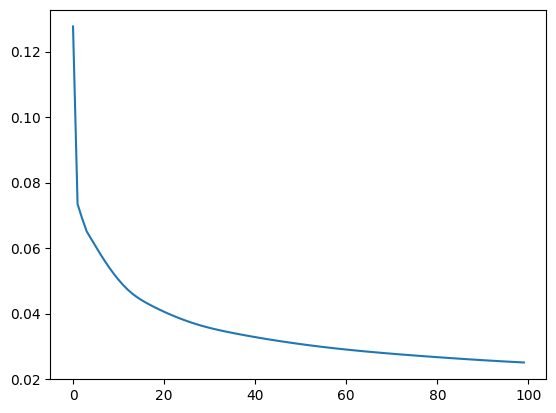

In [88]:
%matplotlib qt

for epoch in range(epochs):

    print("Entering Epoch: ", epoch)
    for dirty, clean, label in tqdm((trainloader)):
        dirty = dirty.view(dirty.size(0), -1).type(torch.FloatTensor)
        clean = clean.view(clean.size(0), -1).type(torch.FloatTensor)
        dirty, clean = dirty.to(device), clean.to(device)

        # -----------------Forward Pass----------------------
        output = model(dirty)
        loss = criterion(output, clean)
        # -----------------Backward Pass---------------------
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        epochloss += loss.item()
    # -----------------Log-------------------------------
    losslist.append(running_loss / l)
    running_loss = 0
    print("======> epoch: {}/{}, Loss:{}".format(epoch, epochs, loss.item()))

    image_res = model(image_test)

    image_res = image_res.view(1, 28, 28)
    image_res = image_res.permute(1, 2, 0).squeeze(2)
    image_res = image_res.detach().cpu().numpy()

    plt.imshow(image_res)
    plt.pause(0.01)

    plt.savefig(f"animation/{epoch}.png")

%matplotlib inline

plt.plot(range(len(losslist)), losslist)

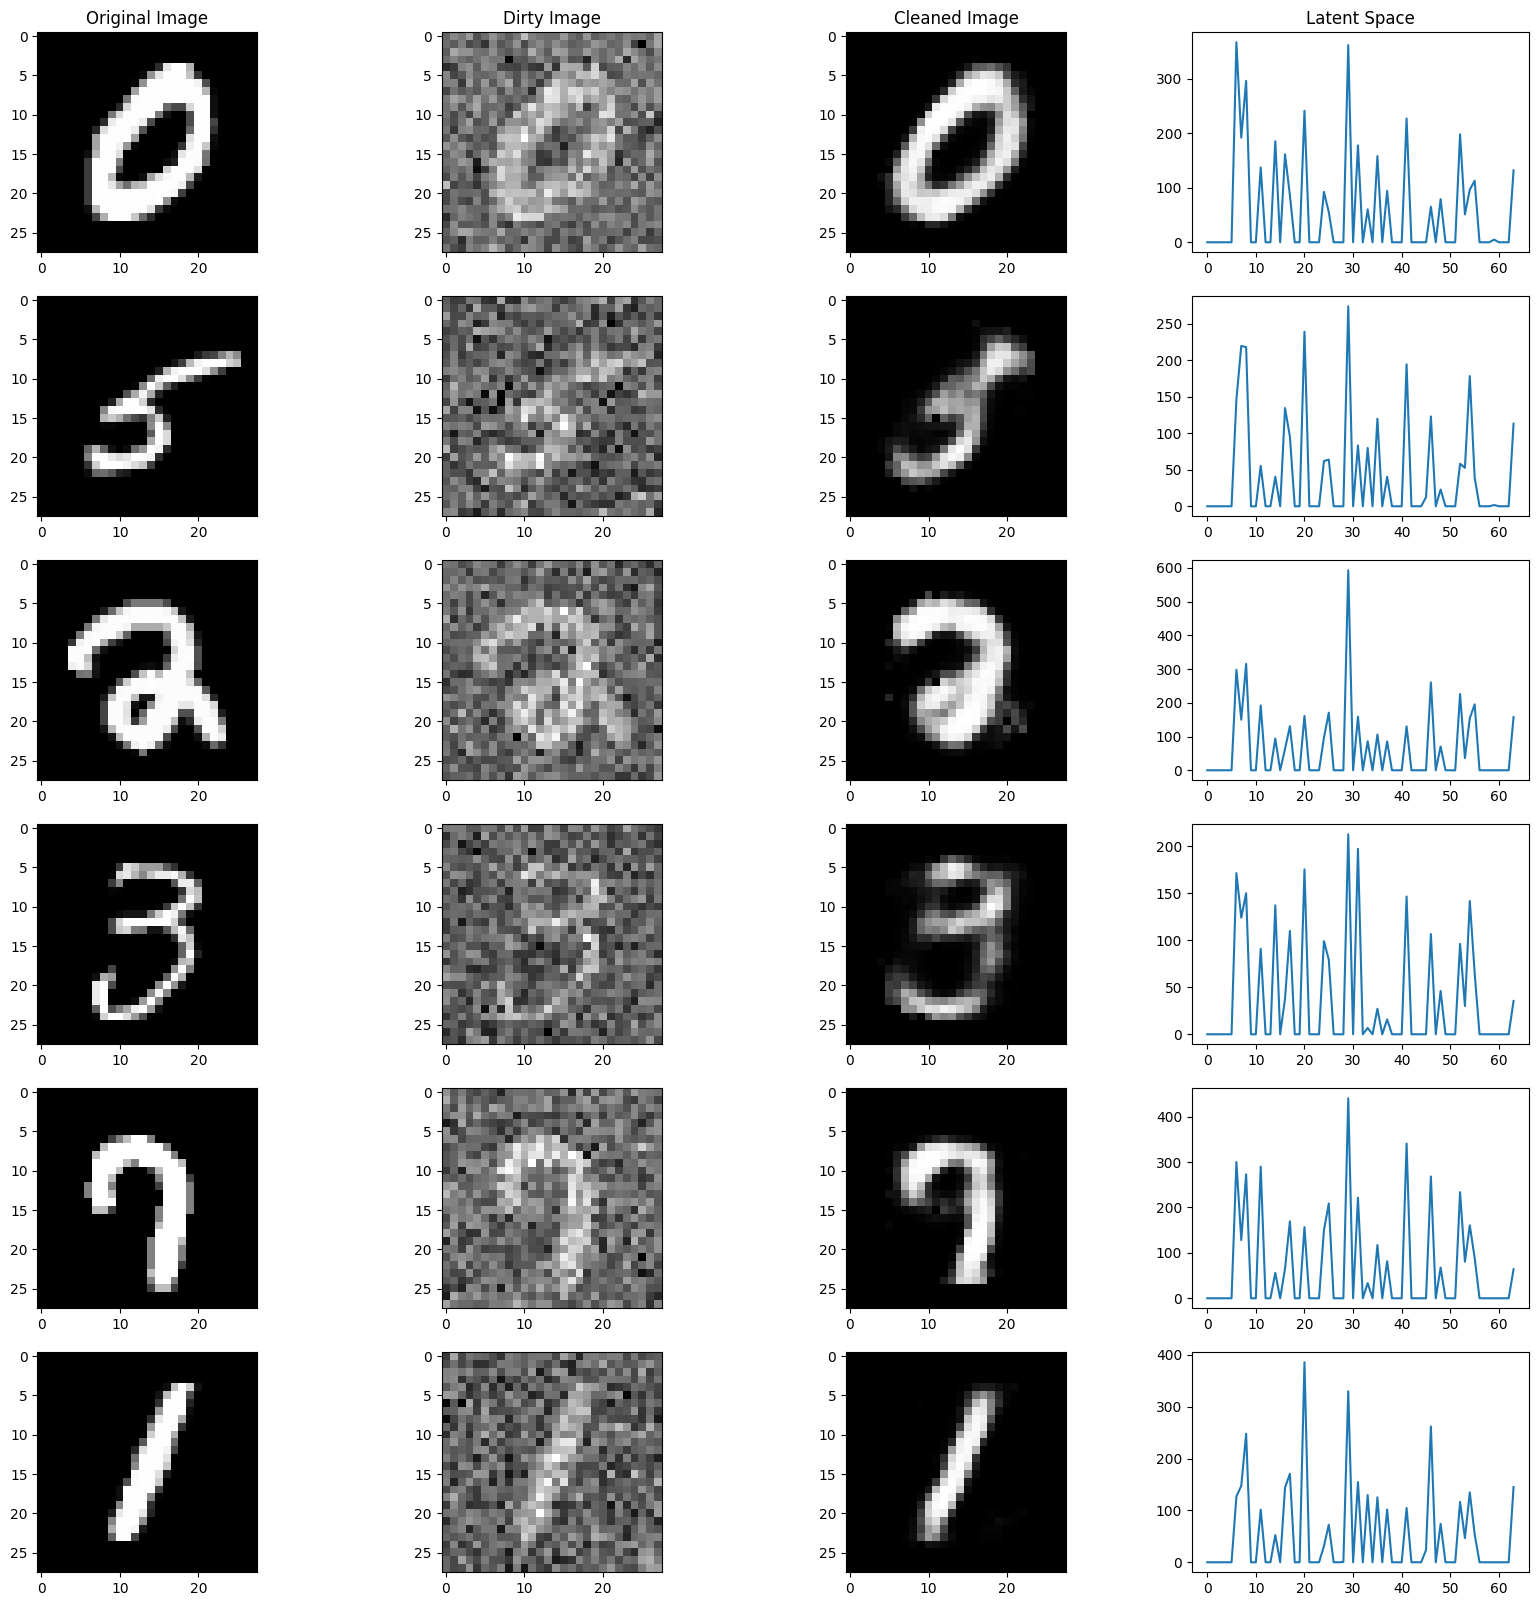

In [89]:
f, axes = plt.subplots(6, 4, figsize=(20, 20))
axes[0, 0].set_title("Original Image")
axes[0, 1].set_title("Dirty Image")
axes[0, 2].set_title("Cleaned Image")
axes[0, 3].set_title("Latent Space")

test_imgs = np.random.randint(0, 10000, size=6)
for idx in range((6)):
    dirty = testset[test_imgs[idx]][0]
    clean = testset[test_imgs[idx]][1]
    label = testset[test_imgs[idx]][2]
    dirty = dirty.view(dirty.size(0), -1).type(torch.FloatTensor)
    dirty = dirty.to(device)
    output = model(dirty)
    output_encoder = model.encoder(dirty)

    output = output.view(1, 28, 28)
    output = output.permute(1, 2, 0).squeeze(2)
    output = output.detach().cpu().numpy()

    dirty = dirty.view(1, 28, 28)
    dirty = dirty.permute(1, 2, 0).squeeze(2)
    dirty = dirty.detach().cpu().numpy()

    clean = clean.permute(1, 2, 0).squeeze(2)
    clean = clean.detach().cpu().numpy()

    latent = output_encoder.detach().cpu().numpy()
    latent = latent.reshape(-1,)

    axes[idx, 0].imshow(clean, cmap="gray")
    axes[idx, 1].imshow(dirty, cmap="gray")
    axes[idx, 2].imshow(output, cmap="gray")
    axes[idx, 3].plot(latent)

plt.show()

In [ ]:
PATH = "model"
torch.save(model.state_dict(), PATH)  # We save the model state dict at PATH

In [13]:
import imageio as iio
import numpy as np

frames = np.stack([iio.imread(f"animation/2_{i}.png")[59:425, 105:475] for i in range(50)], axis = 0)

iio.mimwrite('animation_1d.gif', frames)

C:\Users\gabri\AppData\Local\Temp\ipykernel_196\670719405.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  frames = np.stack([iio.imread(f"animation/2_{i}.png")[59:425, 105:475] for i in range(50)], axis = 0)


C:\Users\gabri\AppData\Local\Temp\ipykernel_196\2238326487.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  a = iio.imread(f"animation/2_0.png")[59:425, 105:475]


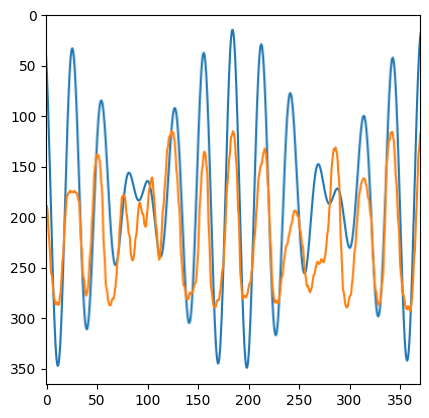

In [12]:
import imageio as iio
import matplotlib.pyplot as plt

a = iio.imread(f"animation/2_0.png")[59:425, 105:475]

plt.imshow(a)
plt.show()